# AI 2004 - Final Project

## HeadCount - Person Counting Web App

By: Group 12 (Tejas Vyas & Amulya Pedapudi)

In this jupyter notebook we go over the creation of model. Our idea is to use ResNet and Transfer Learning to train the model towards learning to count people. 

Let's begin!

### Imports

In [1]:
# Pandas and pyplot to handle data and viz
import pandas as pd
import matplotlib.pyplot as plt

# numpy and scipy for math and array things
import numpy as np
import scipy as sc

# Itertools to iterate through data
import itertools

# Tensorflow and Keras for the model
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import resnet50
from tensorflow.keras import backend

C:\Users\tejas\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tejas\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tejas\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tejas\AppData\Roaming\Python\Python36\site-

### Data Loading

In [2]:
# We get our image ids from labels.csv 
df = pd.read_csv("labels.csv")

# Let's add Image Name concatening the type
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

df.head()

,id,count,image_name
0,1,35,seq_000001.jpg
1,2,41,seq_000002.jpg
2,3,41,seq_000003.jpg
3,4,44,seq_000004.jpg
4,5,41,seq_000005.jpg


We can see above we have ids corresponding to each individual jpgs. 

### Exploratory Data Analysis and Data Preprocessing

Because this is a simple image dataset, our EDA is going to be limited to checking the dataset and reviewing the images. Let's see how much memory our dataset is consuming without the images pre-loaded. We have 2000 records with each corresponding to the individual image.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2000 non-null   int64 
 1   count       2000 non-null   int64 
 2   image_name  2000 non-null   object
dtypes: int64(2), object(1)
memory usage: 47.0+ KB


Let's see some stats about the head count

In [4]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


In order to review the images we'd be using the **ImageDataGenerator** module. Let's create an instane of it and bind the necessary data

In [5]:
# We can use the size 224 and a batch_size of 32
size = 224
batch_size = 32

img_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,  # We rescale the pixels to be between 0 and 1.
    featurewise_center = False, samplewise_center = False,  # set centering mean values to 0
    featurewise_std_normalization = False,  samplewise_std_normalization = False,  # no normalization needed
    zca_whitening = False, 
    horizontal_flip = False, vertical_flip = False, # no image manipulations needed
    validation_split = 0.2,  # dividing data into 80-20 split
    preprocessing_function = resnet50.preprocess_input, #Setting resnet as preprocessing function
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

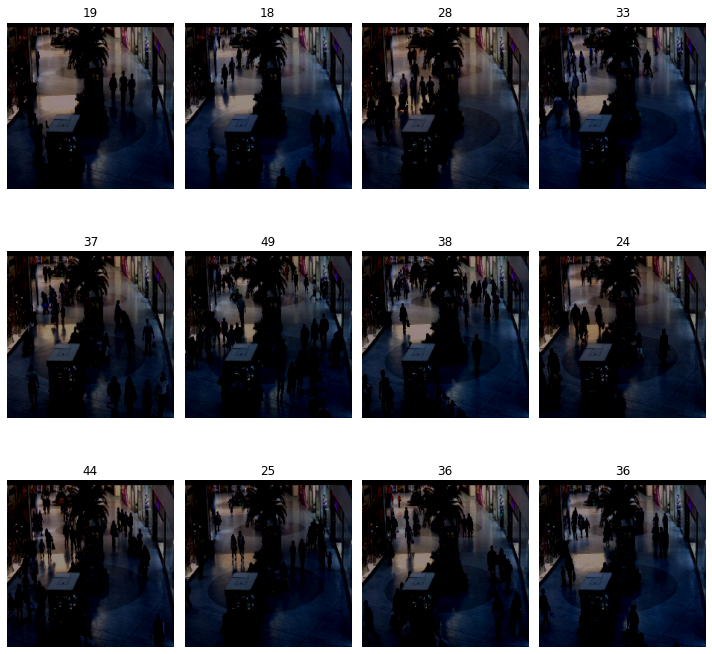

In [7]:
params = dict(
    dataframe=df,
    directory='frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
)

# Splitting Dataset
training_datagen = img_datagen.flow_from_dataframe(subset = 'training', **params)
testing_datagen = img_datagen.flow_from_dataframe(subset = 'validation', **params)

#Let's review a sample of the images
batch = next(training_datagen)
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(12):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

### Model Prototyping

To begin with our model we begin with loading an instance of ResNet50 model with pretrained weights using the imagenet dataset and average pooling applied to it. We can then use this model and transfer learning to train a model which can handle our updated dataset.

In [8]:
resnet_model = resnet50.ResNet50(weights = 'imagenet', include_top = False,  input_shape = (size, size, 3),  pooling = 'avg')

In [9]:
# Output is pooling layer
pooling_x = resnet_model.output

# Adding Single Connected Layer
pooling_x = Dense(1024, activation = 'relu')(pooling_x)

# Output layer - returns number of people in the image
output_y = Dense(1, activation = 'linear')(pooling_x)

# Setting up the model
model = Model(inputs = resnet_model.input, outputs = output_y)

In [10]:
# Let's see how our model looks
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [13]:
# Model Compilation
model.compile( optimizer = Adam(lr = 0.001), loss = "mean_squared_error", 
              metrics = ['mean_squared_error', 'mean_absolute_error'])

# Setting up a Learning Rate Annealer to dynamically decrease learning rate on Plateus
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_mean_squared_error', patience = 3, verbose = 1, factor = 0.25, min_lr = 0.000001)

# Model Fitting
history = model.fit_generator(generator = training_datagen, epochs = 40, 
                              validation_data = testing_datagen, verbose = 2, 
                              callbacks=[learning_rate_reduction])

Epoch 1/40
 - 37s - loss: 45.3415 - mean_squared_error: 45.3415 - mean_absolute_error: 4.3448 - val_loss: 289.4888 - val_mean_squared_error: 289.4888 - val_mean_absolute_error: 15.6458
Epoch 2/40
 - 23s - loss: 8.8699 - mean_squared_error: 8.8699 - mean_absolute_error: 2.3321 - val_loss: 495.0387 - val_mean_squared_error: 495.0387 - val_mean_absolute_error: 21.2103
Epoch 3/40
 - 23s - loss: 5.2049 - mean_squared_error: 5.2049 - mean_absolute_error: 1.8199 - val_loss: 808.3610 - val_mean_squared_error: 808.3610 - val_mean_absolute_error: 27.6231
Epoch 4/40

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
 - 23s - loss: 4.2435 - mean_squared_error: 4.2435 - mean_absolute_error: 1.5988 - val_loss: 856.8101 - val_mean_squared_error: 856.8101 - val_mean_absolute_error: 28.4852
Epoch 5/40
 - 23s - loss: 1.7820 - mean_squared_error: 1.7820 - mean_absolute_error: 1.0503 - val_loss: 883.8757 - val_mean_squared_error: 883.8757 - val_mean_absolute_error: 28.9561
Ep

Let's save the model

In [44]:
model.save("headcount_model.hdf5")

### Model Analysis

We can now review how the loss changed during training iterations

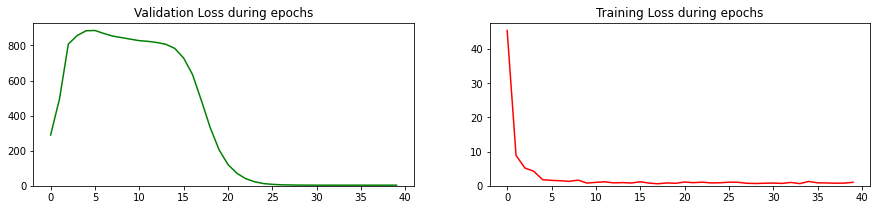

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (15, 3))

ax[0].set_ylim(top = np.max(history.history['val_loss'])*1.05)
ax[1].set_ylim(top = np.max(history.history['loss'])*1.05)

ax[0].set_title("Validation Loss during epochs")
ax[1].set_title("Training Loss during epochs")

ax[0].plot(history.history['val_loss'], color = 'g')
ax[1].plot(history.history['loss'], color = 'r')

It seems like our annealer did help, as the validation loss decreased significantly during the course after 12th epoch. Now let's create predictions on the entire validation set to review our performance

In [49]:
# Going through the generators and labels and making predictions for each
testing_datagen.reset()
labels = []
preds = []
for i in range(len(testing_datagen)):
    img = next(testing_datagen)
    print(img[0].shape)
    #Predict
    pred_i = model.predict(img[0])[:,0]
    labels_i = img[1]
    labels.append(labels_i)
    preds.append(pred_i)

# Create a concatenated array for all labels and preds
cat_labels = np.concatenate(labels)
cat_preds = np.concatenate(preds)

# Rounding the predictions to get a better idea of closeness
for i in range(len(cat_preds)):
    cat_preds[i] = round(cat_preds[i])

df_preds = pd.DataFrame({'Actual Count': cat_labels, 'Predicted Count': cat_preds})

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(16, 224, 224, 3)


Let's see our predictions!

In [41]:
df_preds

,Actual Count,Predicted Count
0,25,26.0
1,35,37.0
2,34,32.0
3,28,29.0
4,28,33.0
...,...,...
395,21,20.0
396,18,20.0
397,34,31.0
398,28,26.0


Looks like our regression algorithm is really close! Let's also review this graphically

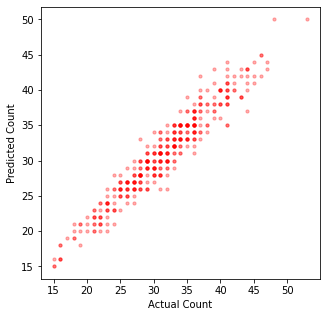

In [47]:
ax = df_preds.plot.scatter('Actual Count', 'Predicted Count', 
                           alpha = 0.3, s = 10, figsize = (5,5), c = "r")
plt.show()

An amazingly close trendline suggests our model is decently trained to count people! We can now incorporate this into the flask app to get the head count.